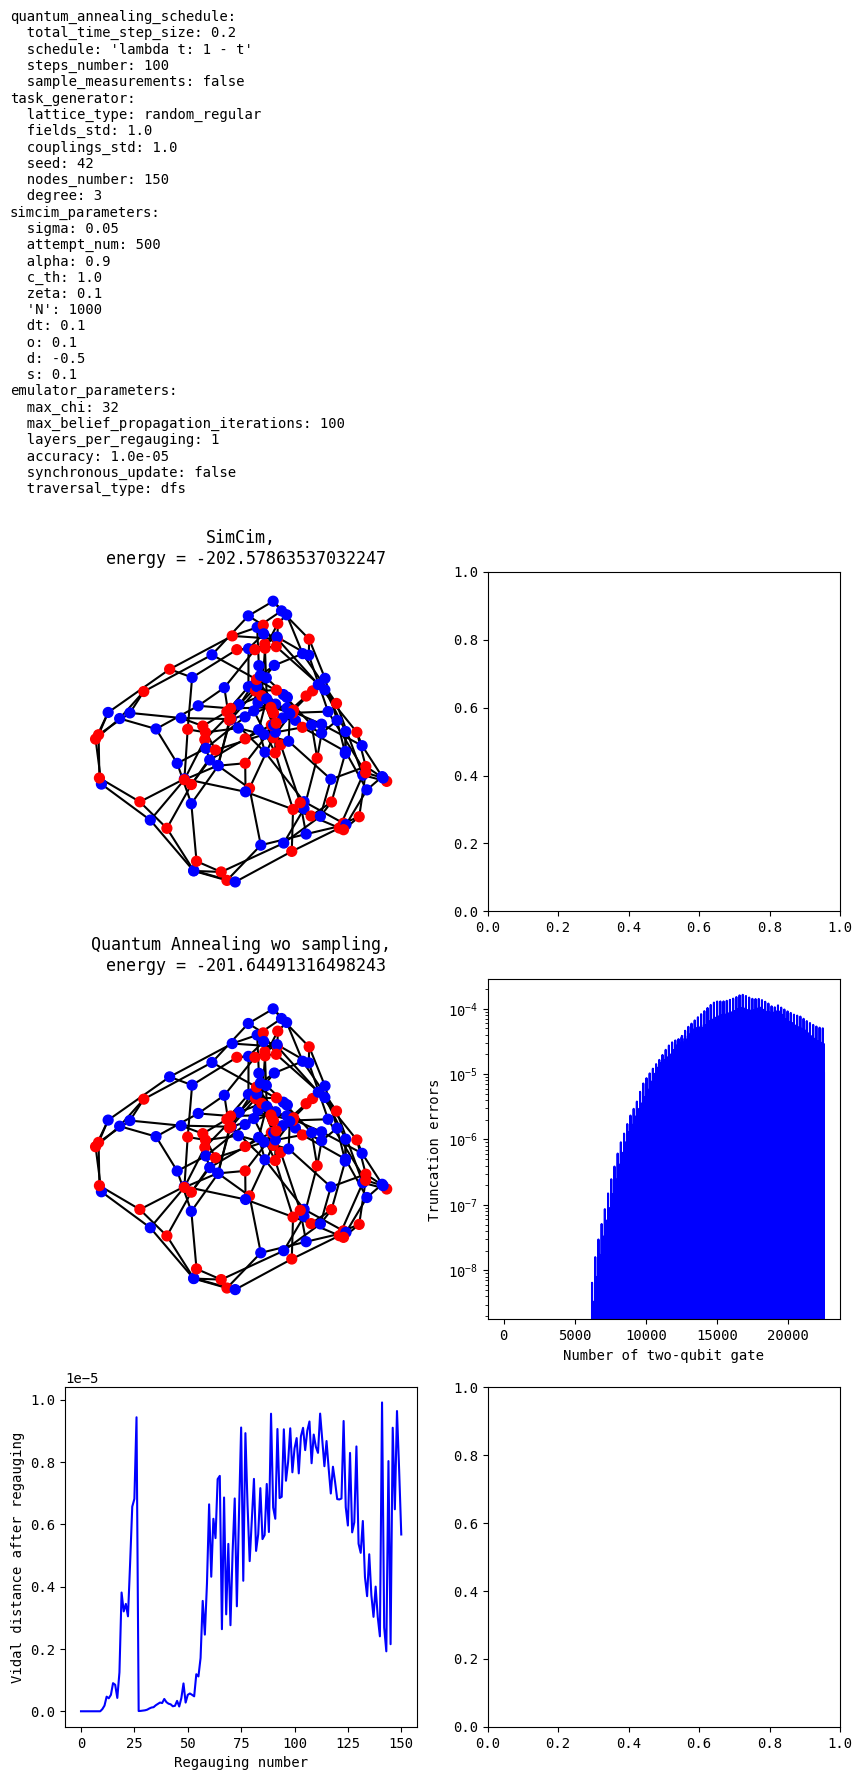

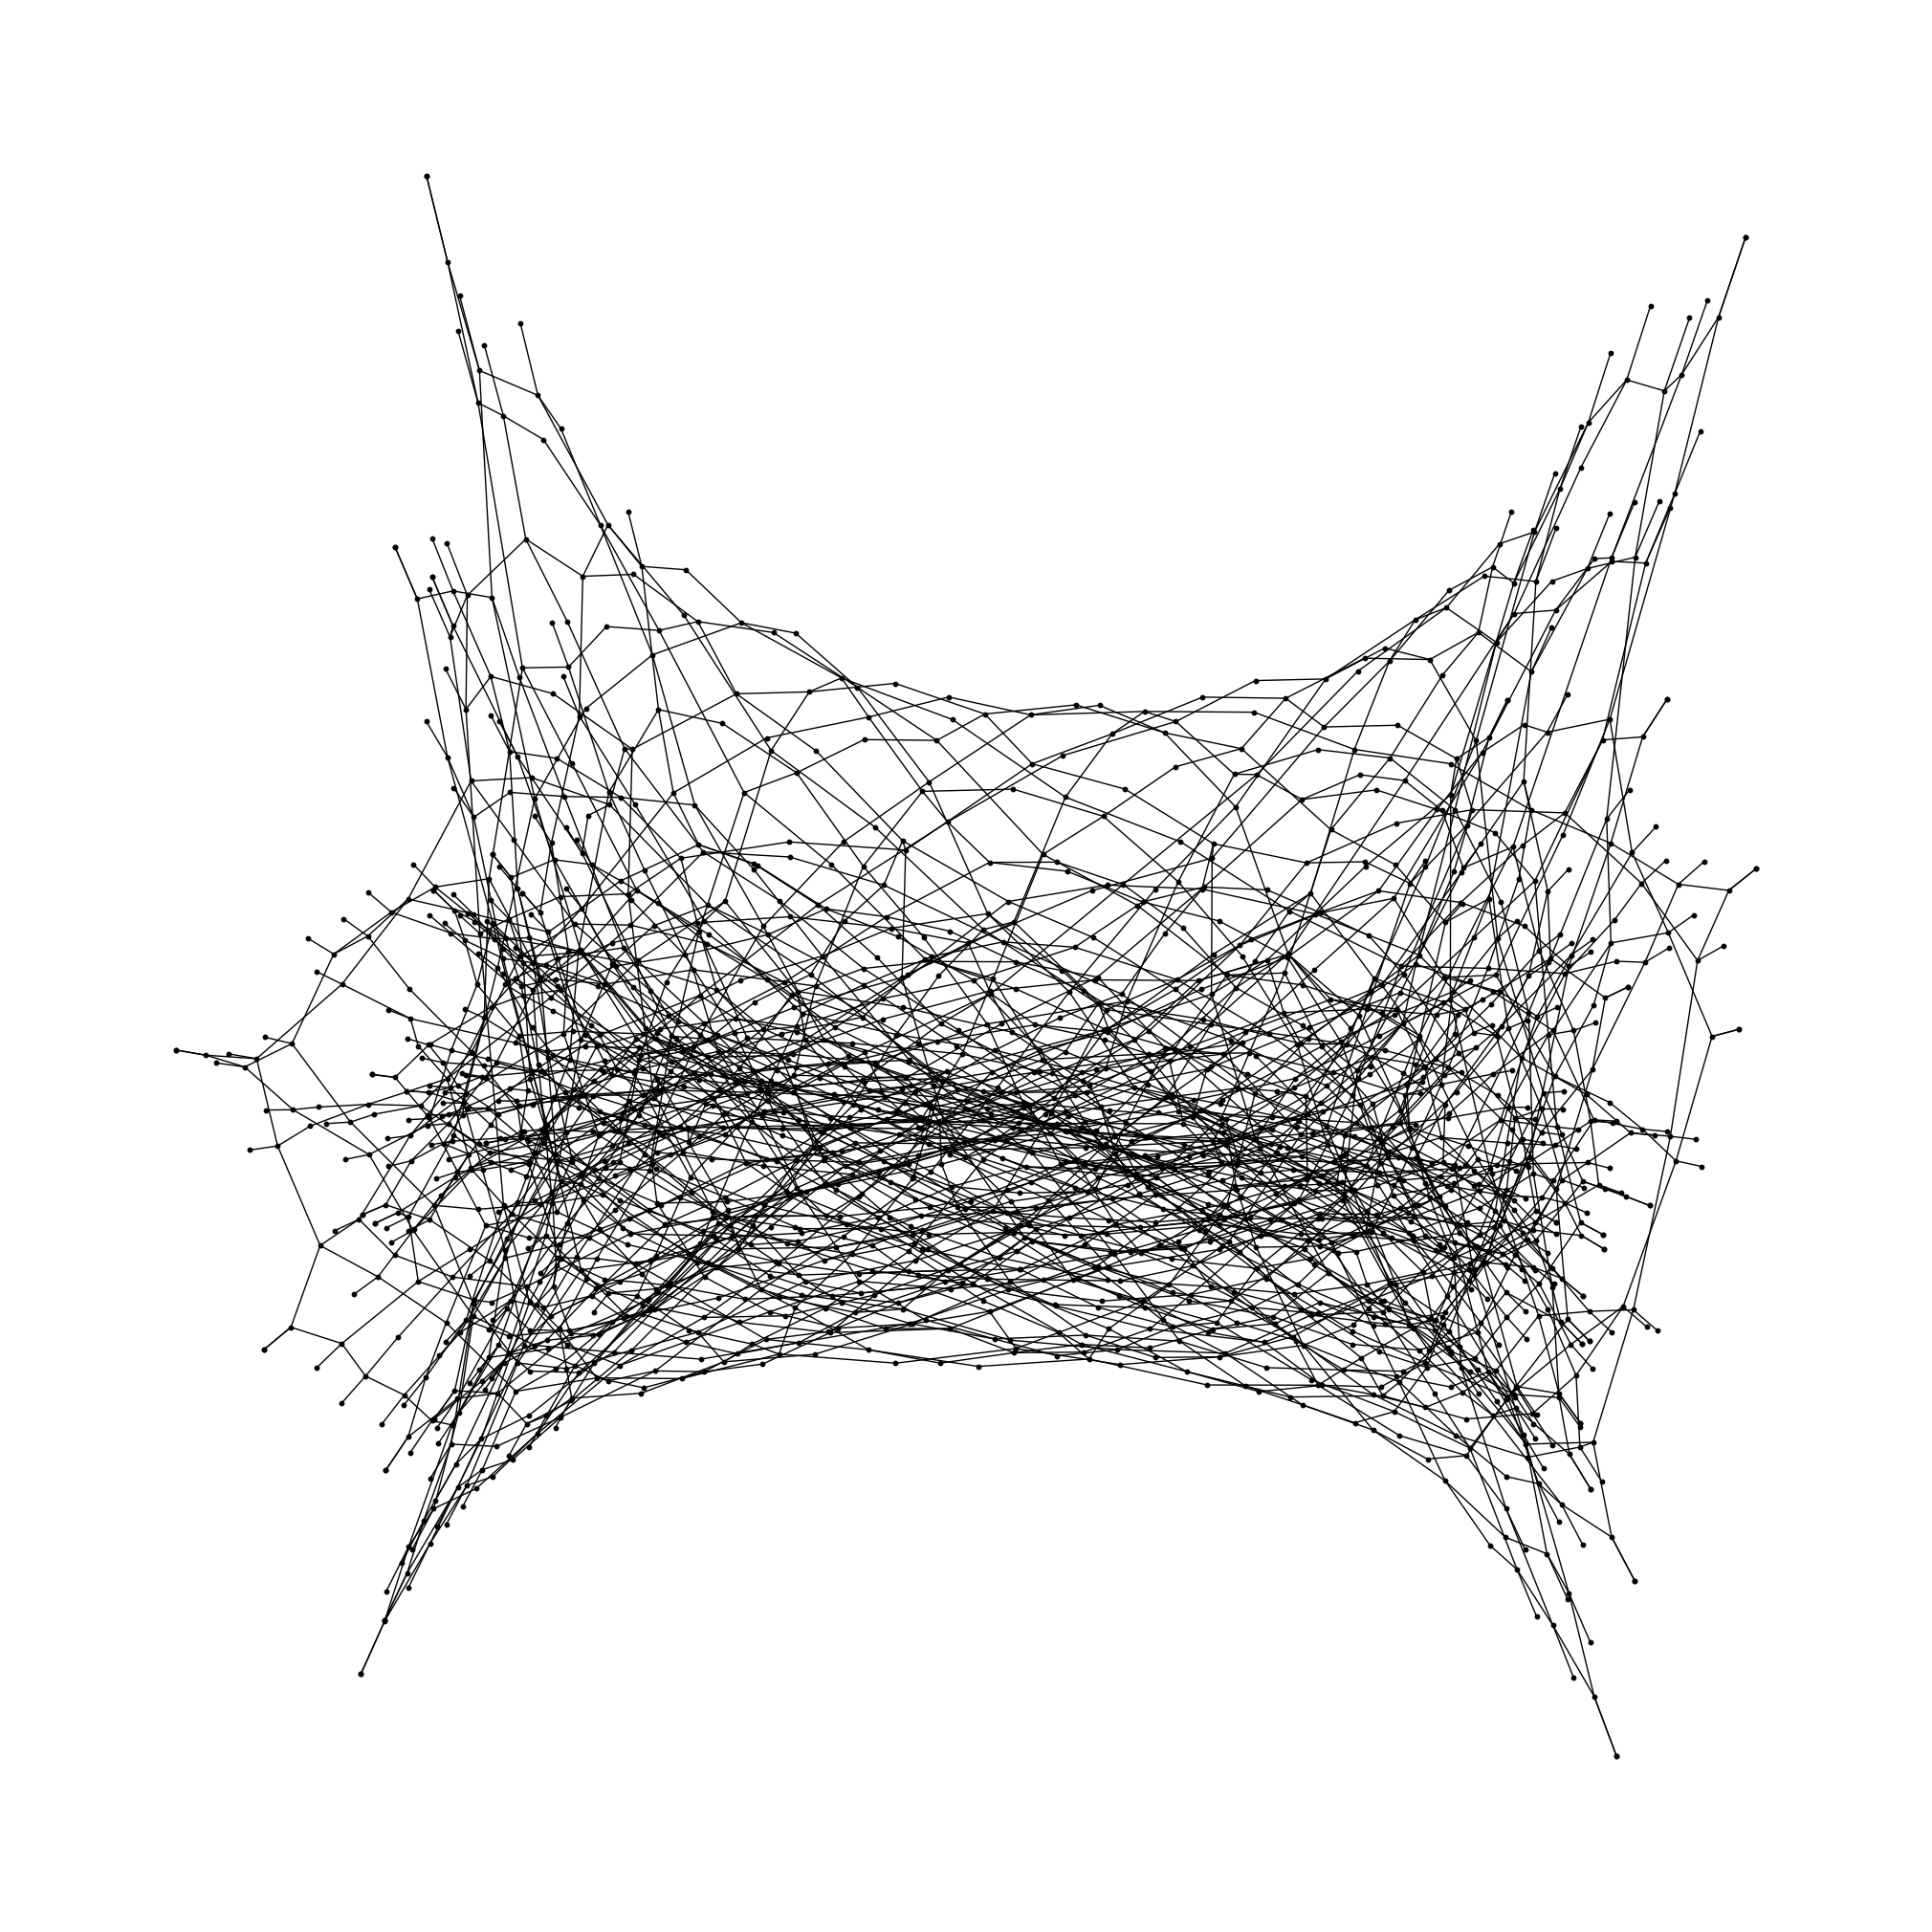

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["font.family"] = "monospace"
import h5py
import numpy as np
import networkx as nx
import yaml

script_dir = os.getcwd()
results_dir_path = f"{script_dir}/outputs/2024-04-26/06-56-02"
results_path = f"{results_dir_path}/result"
config_path = f"{results_dir_path}/.hydra/config.yaml"
with open(config_path, "r") as f:
    raw_config = f.read()
    config = yaml.safe_load(raw_config)
sample_measurements = int(config["quantum_annealing_schedule"]["sample_measurements"])
layers_number = int(config["quantum_annealing_schedule"]["steps_number"])
with h5py.File(results_path, "r") as f:
    circuit = nx.Graph()
    fields = np.array(f["fields"])
    pairs = np.array(f["coupled_spin_pairs"])
    truncation_errors = np.array(f["truncation_errors"])
    entropies = np.array(f["entropies"])
    coupling_amplitudes = np.array(f["coupling_amplitudes"])
    simcim_coloring = list(map(lambda x: "blue" if x > 0 else "red", np.array(f["simcim_configuration"])))
    quantum_annealing_color_wo_sampling = list(map(lambda x: "blue" if x > 0.5 else "red", np.array(f["density_matrices"])[:, 0, 0]))
    simcim_energy = np.array(f["simcim_energy"])
    quantum_annealer_energy_wo_sampling =  np.array(f["quantum_annealer_energy_wo_sampling"])
    if sample_measurements:
        quantum_annealer_coloring = list(map(lambda x: "blue" if x > 0 else "red", np.array(f["quantum_annealer_configuration"])))
        quantum_annealer_energy = np.array(f["quantum_annealer_energy"])
    vidal_distances_after_regauging = np.array(f["vidal_distances_after_regauging"])
    for id in range(fields.shape[0]):
        circuit.add_node(id)
    for pair in pairs:
        circuit.add_edge(pair[0], pair[1])
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 15))
    fig.text(0.07, 0.9, f"{raw_config}\n\n")
    ax1.set_title(f"SimCim,\n energy = {simcim_energy}")
    ax3.set_title(f"Quantum Annealing wo sampling,\n energy = {quantum_annealer_energy_wo_sampling}")
    nx.draw_spectral(circuit, node_size=50, width=1.5, node_color=simcim_coloring, ax=ax1)
    nx.draw_spectral(circuit, node_size=50, width=1.5, node_color=quantum_annealing_color_wo_sampling, ax=ax3)
    if sample_measurements:
        ax2.set_title(f"Quantum Annealing,\n energy = {quantum_annealer_energy}")
        nx.draw_spectral(circuit, node_size=50, width=1.5, node_color=quantum_annealer_coloring, ax=ax2)
    ax4.plot(truncation_errors, 'b')
    ax4.set_ylabel("Truncation errors")
    ax4.set_xlabel("Number of two-qubit gate")
    ax4.set_yscale('log')
    ax5.plot(vidal_distances_after_regauging, 'b')
    ax5.set_xlabel("Regauging number")
    ax5.set_ylabel("Vidal distance after regauging")
    ax6.plot(entropies, 'b')
    ax6.set_xlabel("Number of two-qubit gate")
    ax6.set_ylabel("Entropy")
    plt.savefig(f"{script_dir}/optimization_results.pdf",  bbox_inches="tight")
    tn_graph = nx.Graph()
    for id in range(fields.shape[0]):
        tn_graph.add_node(id)
    front_layer_ids = { key: value for key, value in zip(range(fields.shape[0]), range(fields.shape[0])) }
    for layer in range(layers_number // 20):
        for pair in pairs:
            id = (layer, pair[0], pair[1])
            tn_graph.add_node(id)
            tn_graph.add_edge(id, front_layer_ids[pair[0]])
            tn_graph.add_edge(id, front_layer_ids[pair[1]])
            front_layer_ids[pair[0]] = id
            front_layer_ids[pair[1]] = id
        for i in range(fields.shape[0]):
            id = (layer, i)
            tn_graph.add_node(id)
            tn_graph.add_edge(id, front_layer_ids[i])
            front_layer_ids[i] = id
    plt.figure(figsize=(20, 20))
    nx.draw_spectral(tn_graph, node_size=10, node_color='black')
    plt.savefig(f"{script_dir}/tensor_network.pdf", bbox_inches="tight")